In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

from qiskit.quantum_info import Statevector, random_statevector

from qiskit.visualization import plot_distribution, plot_bloch_multivector
from qiskit.visualization import array_to_latex

from qiskit_aer import AerSimulator

In [41]:
# Definición de funciones para implementar las diversas etapas del circuito de teletransportación cuántica
def crear_estado_bell00(qc, a, b):
    qc.h(a)
    qc.cx(a,b)
    
def circuito_de_alice(qc, q2send, beta0):
    qc.cx(q2send, beta0)
    qc.h(q2send)
    
def medicion_de_alice(qc, a, b, crz, crx):
    qc.barrier()
    qc.measure(a, crz)
    qc.measure(b, crx)
    qc.barrier()
    qc.barrier()
    
def circuito_de_bob(qc, beta1, m1, m2):
    # Bob usa los bits clásicos para aplicar compuertas de manera condicional
    with qc.if_test((m1, 1)):
        qc.z(beta1)
    with qc.if_test((m2, 1)):
        qc.x(beta1)

In [42]:
# Definición de registros de qubits de entrada
QEntanglem_A = QuantumRegister(1, name='Qubit_A')
QEntanglem_B = QuantumRegister(1, name='Qubit_B')
Q2teletransport = QuantumRegister(1, name='Qubit_C')

# Definición de registros de bits clásicos para medida
crz = ClassicalRegister(1, name='crz')
crx = ClassicalRegister(1, name='crx')
crbob = ClassicalRegister(1, name='crbob')

# Definición del circuito de teletransportación cuántica
teleport_cir = QuantumCircuit(QEntanglem_A, QEntanglem_B, Q2teletransport, crz, crx, crbob)

<IPython.core.display.Latex object>

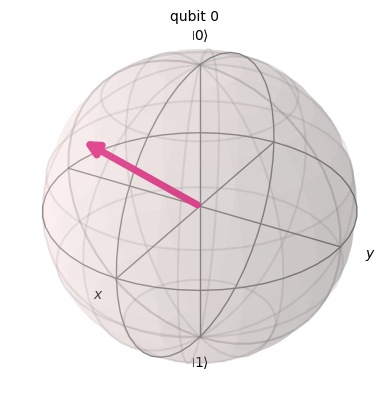

Las probabilidades de este estado cuántico aleatorio son: [0.81463264 0.18536736]


In [ ]:
# Definición de un estado cuántico aleatorio de entrada para ser teletransportado
qrandom = random_statevector(2)
display(array_to_latex(Statevector(qrandom), prefix="\\ket{\\psi} = "))

fig = plot_bloch_multivector(Statevector(qrandom))
plt.show()

print("Las probabilidades de este estado cuántico aleatorio son:", Statevector(qrandom).probabilities())

In [44]:
# Ensamblado del circuito completo de la Teletransportación Cuántica
init_gate = QuantumCircuit(1, name="Random Input") 
init_gate.initialize(qrandom,0)

teleport_cir.append(init_gate.to_instruction(), Q2teletransport)
teleport_cir.barrier() # Uso de "barrier" (barrera) para separar las diversas etapas

crear_estado_bell00(teleport_cir, QEntanglem_A, QEntanglem_B)
teleport_cir.barrier()

circuito_de_alice(teleport_cir, Q2teletransport, QEntanglem_A)

# El resultado de la medida realizada por Alice se envía a Bob por un canal clásico
# (correo electronico, Whtspp, llamada telefónica).
# Este canal clásico se representa por la doble barrera indicada en el circuito.
medicion_de_alice(teleport_cir, Q2teletransport, QEntanglem_A, crz, crx)

circuito_de_bob(teleport_cir, QEntanglem_B, crz, crx)

In [45]:
# Definición de simuladores requeridos
statevector_simulator = AerSimulator(method='statevector')
circuit_simulator = AerSimulator()

In [46]:
# Simulación del Vector de Estado a la salida del circuito
teleport_cir_statevector = teleport_cir.copy()
teleport_cir_statevector.save_statevector()

In [47]:
# Transpilación para posteriormente realizar la simulación del vector de estado resultante
circ_statevector = transpile(teleport_cir_statevector, statevector_simulator)

# Ejecución y obtención del statevector
result = statevector_simulator.run(circ_statevector).result()
statevector = result.get_statevector(circ_statevector)

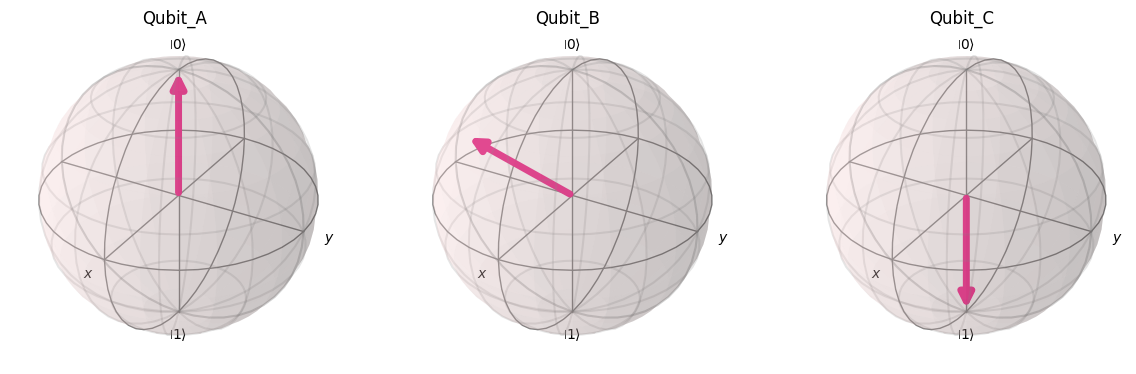

<IPython.core.display.Latex object>

In [ ]:
fig = plot_bloch_multivector(statevector)

custom_labels = ['Qubit_A', 'Qubit_B', 'Qubit_C']
for ax, label in zip(fig.axes, custom_labels):
    ax.set_title(label, pad=28)
plt.show()

display(array_to_latex(Statevector(statevector), prefix="\\ket{Salida_{statevector}} = "))

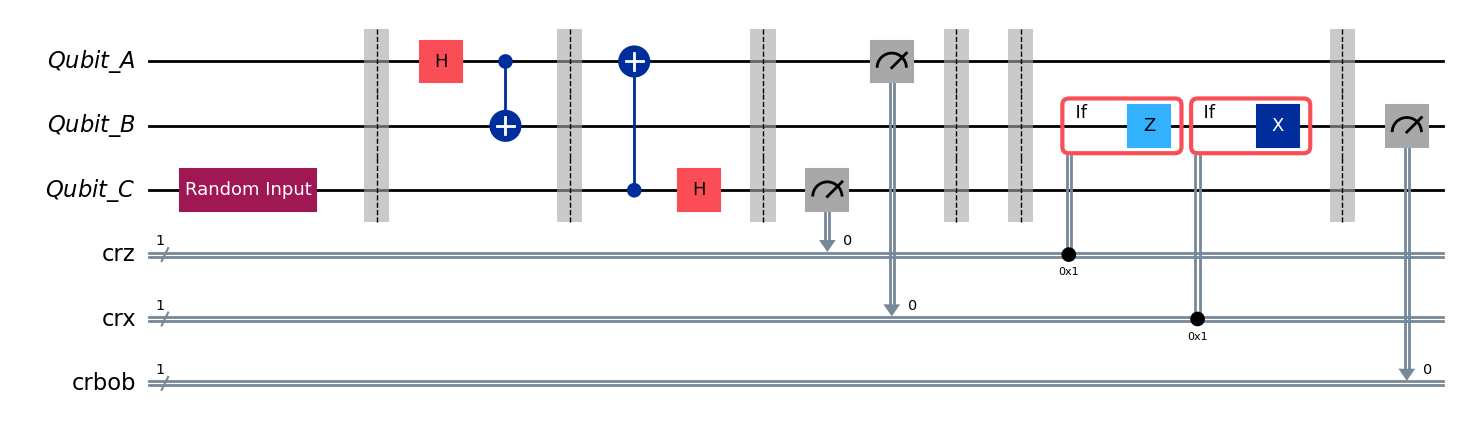

In [49]:
teleport_cir.barrier() # Uso de "barrier" (barrera) para separar las diversas etapas
teleport_cir.measure(QEntanglem_B, crbob)

# Gráfica del circuito completo de Teletransportación Cuántica
teleport_cir.draw('mpl')
plt.show()

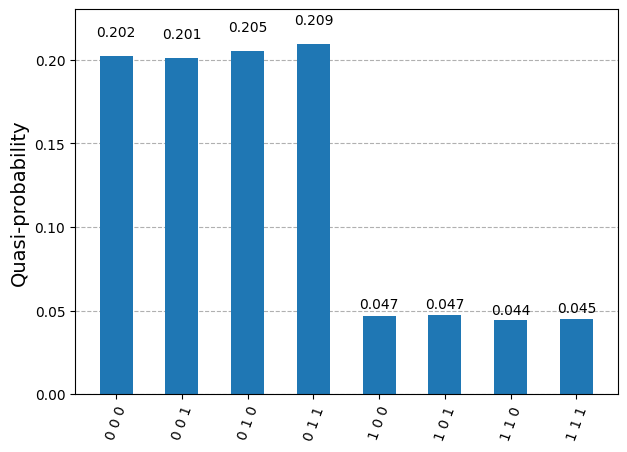

In [ ]:
# Simulación del circuito completo
shots = 8192
teleport_result = circuit_simulator.run(teleport_cir.decompose(reps=1), shots=shots).result()
data = teleport_result.get_counts(teleport_cir)

plot_distribution(data)
# En este conjunto de datos de probabilidad está todo el universo del circuito. 
# Los qubits q0 y q1 corresponden a los obtenidos por Alice antes de la medida.
# Y el qubit q2 corresponde al recibido por Bob. 
plt.show()

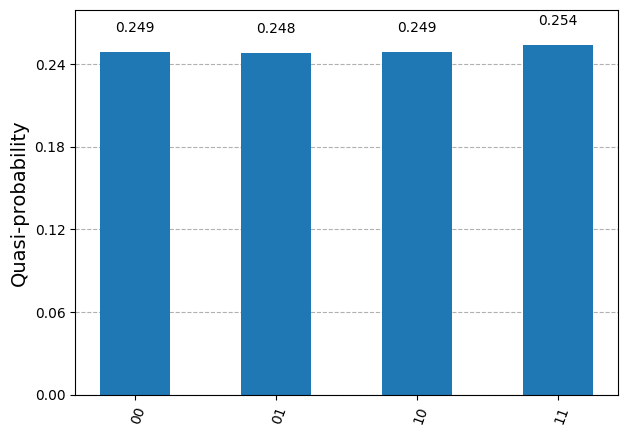

In [51]:
# Con las siguientes instrucciones se pueden extraer de manera más clara los qubits de Alice.
alice = {}
alice['00'] = data['0 0 0'] + data['1 0 0']
alice['10'] = data['0 1 0'] + data['1 1 0']
alice['01'] = data['0 0 1'] + data['1 0 1']
alice['11'] = data['0 1 1'] + data['1 1 1']

plot_distribution(alice)
plt.show()

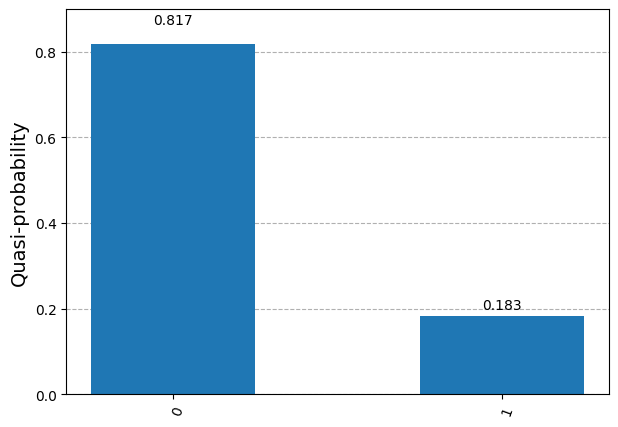

In [52]:
# Y con las siguientes instrucciones se puede extraer de manera más clara el qubit de Bob.
bob = {}
bob['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']

plot_distribution(bob)
plt.show()